<a href="https://colab.research.google.com/github/Patrick-Moe/Riot-League-Stats/blob/main/Summoner_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pydotplus
import graphviz
from IPython.display import Image


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import ensemble, svm, tree
from sklearn.model_selection import GridSearchCV, cross_val_score
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score


# Retrieving input data

---



In [1]:
api_key = " "

In [2]:
api_key

' '

In [ ]:
#create a function that gets the players name and puts it into the preloaded api code
def get_player(summoner_name_input, api_key):
  api_url = (
      "https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/" +
      summoner_name_input + #getting the summoner name typed by the input
      "?api_key="+
      api_key #using api key above
  )
  while True:
    resp=requests.get(api_url)
    if resp.status_code ==200: #This is riot game's all good code
      print("Retrieving now!")
      break
    else:
      print("Either not a player or you mistyped")
      summoner_name_input = input("Please enter a valid summoner name: ") #recieves the input
  data = resp.json()
  return data

In [ ]:
summoner_name = input("Please enter a summoner name: (punctuation matters :))") #a smiley face to let them know its ok to make mistakes
player_data = get_player(summoner_name, api_key)
print("Summoner Name:", player_data["name"])
print("Summoner ID:", player_data["id"])
print("Summoner Level:", player_data["summonerLevel"])
print("Summoner Puuid:", player_data['puuid'])

Please enter a summoner name: (punctuation matters :))raptorfish
Retrieving now!
Summoner Name: Raptorfish
Summoner ID: IvI451Kw7nxFUd1thU6scv0K5OebGpR2iX8tP_uYmjY5g7w
Summoner Level: 327
Summoner Puuid: xO7ReNRSttQs9M0z1oujeYThDtyMZmqXHX0vgMdMS80xOLUnrbDdc5gOK_YhCcDCybyfjpqvsYuaZg


In [ ]:
puuid=player_data['puuid']
puuid #just makes it easier to save as independent variables

'xO7ReNRSttQs9M0z1oujeYThDtyMZmqXHX0vgMdMS80xOLUnrbDdc5gOK_YhCcDCybyfjpqvsYuaZg'

In [ ]:
player = player_data['name']
player

'Raptorfish'

In [ ]:
def get_ranked_match_ids(api_key, puuid): #a function to get the ranked match ID's using the prior output
    base_url = f"https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids"
    params = {
        "type": "ranked",
        "start": 0,
        "count": 100,
        "api_key": api_key
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        match_ids = response.json()
        return match_ids
    elif response.status_code == 429:  #incase we go over the riot api limits
                print("Rate limit exceeded. Waiting for 1 minute...")
                time.sleep(60)
    else:
        print("Error retrieving ranked match IDs.")
        return []
ranked_match_ids = get_ranked_match_ids(api_key, puuid)

In [ ]:
print("Ranked Match IDs:")
print(ranked_match_ids)
print(len(ranked_match_ids))

Ranked Match IDs:
['NA1_4756928326', 'NA1_4756913566', 'NA1_4756897535', 'NA1_4749351453', 'NA1_4749342178', 'NA1_4749323908', 'NA1_4748501403', 'NA1_4748461168', 'NA1_4748410267', 'NA1_4748370746', 'NA1_4748327695', 'NA1_4747619363', 'NA1_4747593006', 'NA1_4747551508', 'NA1_4747532874', 'NA1_4747489346', 'NA1_4746563386', 'NA1_4746526497', 'NA1_4741690134', 'NA1_4741580309', 'NA1_4741282668', 'NA1_4739845704', 'NA1_4739830912', 'NA1_4739808771', 'NA1_4739781342', 'NA1_4739762210', 'NA1_4735719224', 'NA1_4735696729', 'NA1_4734789796', 'NA1_4734744961', 'NA1_4734605736', 'NA1_4734576311', 'NA1_4734552904', 'NA1_4733763934', 'NA1_4733730892', 'NA1_4733649726', 'NA1_4733631980', 'NA1_4733611874', 'NA1_4717939965', 'NA1_4717011890', 'NA1_4716961519', 'NA1_4716109545', 'NA1_4716085973', 'NA1_4716032503', 'NA1_4715109010', 'NA1_4715084784', 'NA1_4715050081', 'NA1_4715015664', 'NA1_4713021886', 'NA1_4712960180', 'NA1_4710319829', 'NA1_4709377611', 'NA1_4709353358', 'NA1_4709306037', 'NA1_4708

In [ ]:
def get_match_details(api_key, match_id):  #get the match details
    base_url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}"
    params = {
        "api_key": api_key
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        match_details = response.json()
        return match_details
    elif response.status_code == 429:
                print("Rate limit exceeded. Waiting for 1 minute...")
                time.sleep(60)
    else:
        print(f"Error retrieving match details for match ID: {match_id}")
        return None

In [ ]:
def fetch_and_save_ranked_match_ids(api_key, ranked_match_ids): #run through every ranked match ID above
    saved_data = {} #The end dictionary

    for match_id in ranked_match_ids:
        match_details = get_match_details(api_key, match_id)
        if match_details:
            saved_data[match_id] = match_details

    return saved_data

saved_match_details = fetch_and_save_ranked_match_ids(api_key, ranked_match_ids) #store the details into this dictionary


Rate limit exceeded. Waiting for 1 minute...


The previous is the last api call. Only data from here on

In [ ]:
player_name = player

match_totals = {} #the end frame

for match_id, match_details in saved_match_details.items():
    game_mode = match_details.get("info", {}).get("gameMode", "")

    if game_mode == "CLASSIC": #make sure the ranked game is Summoners rift 5v5
        participants = match_details.get("info", {}).get("participants", [])

        for participant in participants: #a for loop to go over every participant in the saved file
            if participant.get("summonerName", "").lower() == player_name.lower(): #make sure it matches the input
                team_id = participant.get("teamId", 100) #parameters
                income = participant.get("goldEarned", 0)
                kills = participant.get("kills", 0)
                deaths = participant.get("deaths", 0)
                assists = participant.get("assists", 0)
                creep_score = participant.get("totalMinionsKilled", 0)
                win = 1 if participant.get("win", False) else 0
                vision_score = participant.get("visionScore", 0)
                        #Next calculates the team score of dragon and baron. Both important for league of legends
                own_team_dragons = sum(participant.get("dragonKills", 0) for participant in participants if participant.get("teamId") == team_id)
                own_team_barons = sum(participant.get("baronKills", 0) for participant in participants if participant.get("teamId") == team_id)

                # Calculate total elapsed time in seconds
                game_start_time = match_details['info']['gameStartTimestamp']
                game_end_time = match_details['info']['gameEndTimestamp']
                total_elapsed_time_seconds = round((game_end_time - game_start_time) / 1000)  # Convert to seconds and round
                #save the end results
                match_totals[match_id] = {
                    "Income": income,
                    "Kills": kills,
                    "Deaths": deaths,
                    "Assists": assists,
                    "Creep Score": creep_score,
                    "Win": win,
                    "Vision Score": vision_score,
                    "Own Team Dragons": own_team_dragons,
                    "Own Team Barons": own_team_barons,
                    "Total Elapsed Time (seconds)": total_elapsed_time_seconds
                }

# Print the match_totals dictionary for the specified player
for match_id, totals in match_totals.items():
    print(f"Match ID: {match_id}")
    print(f"Player {player_name} - {totals}")
    print("-" * 50)  # Print a separator between matches


Match ID: NA1_4748501403
Player Raptorfish - {'Income': 8605, 'Kills': 2, 'Deaths': 9, 'Assists': 7, 'Creep Score': 45, 'Win': 1, 'Vision Score': 66, 'Own Team Dragons': 3, 'Own Team Barons': 2, 'Total Elapsed Time (seconds)': 1870}
--------------------------------------------------
Match ID: NA1_4748461168
Player Raptorfish - {'Income': 10901, 'Kills': 3, 'Deaths': 3, 'Assists': 22, 'Creep Score': 17, 'Win': 1, 'Vision Score': 81, 'Own Team Dragons': 3, 'Own Team Barons': 2, 'Total Elapsed Time (seconds)': 2525}
--------------------------------------------------
Match ID: NA1_4748410267
Player Raptorfish - {'Income': 10418, 'Kills': 3, 'Deaths': 13, 'Assists': 17, 'Creep Score': 35, 'Win': 0, 'Vision Score': 70, 'Own Team Dragons': 1, 'Own Team Barons': 1, 'Total Elapsed Time (seconds)': 2187}
--------------------------------------------------
Match ID: NA1_4748370746
Player Raptorfish - {'Income': 10355, 'Kills': 4, 'Deaths': 6, 'Assists': 10, 'Creep Score': 50, 'Win': 1, 'Vision Sco

# Ranked Dataframe

---



In [ ]:
df = pd.DataFrame.from_dict(match_totals, orient="index")
df #make it into a dataframe

,Income,Kills,Deaths,Assists,Creep Score,Win,Vision Score,Own Team Dragons,Own Team Barons,Total Elapsed Time (seconds)
NA1_4748501403,8605,2,9,7,45,1,66,3,2,1870
NA1_4748461168,10901,3,3,22,17,1,81,3,2,2525
NA1_4748410267,10418,3,13,17,35,0,70,1,1,2187
NA1_4748370746,10355,4,6,10,50,1,89,3,2,2043
NA1_4747619363,9753,2,12,21,32,0,67,3,0,2261
...,...,...,...,...,...,...,...,...,...,...
NA1_4682799987,8211,2,10,7,21,0,84,1,0,2070
NA1_4682749357,17367,11,9,12,228,1,51,4,2,2395
NA1_4682056050,11569,1,15,28,22,0,103,3,2,2645
NA1_4682022769,9079,1,7,13,50,1,84,4,1,2391


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, NA1_4748501403 to NA1_4678619912
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Income                        77 non-null     int64
 1   Kills                         77 non-null     int64
 2   Deaths                        77 non-null     int64
 3   Assists                       77 non-null     int64
 4   Creep Score                   77 non-null     int64
 5   Win                           77 non-null     int64
 6   Vision Score                  77 non-null     int64
 7   Own Team Dragons              77 non-null     int64
 8   Own Team Barons               77 non-null     int64
 9   Total Elapsed Time (seconds)  77 non-null     int64
dtypes: int64(10)
memory usage: 6.6+ KB


In [ ]:
df.describe()

,Income,Kills,Deaths,Assists,Creep Score,Win,Vision Score,Own Team Dragons,Own Team Barons,Total Elapsed Time (seconds)
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,10834.727273,4.506494,5.844156,8.428571,91.168831,0.454545,43.480519,2.051948,0.649351,1797.402597
std,4076.392654,3.607825,3.524594,6.146091,83.952431,0.501195,25.774636,1.385034,0.774023,535.139782
min,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,102.000000
25%,8211.000000,2.000000,3.000000,5.000000,27.000000,0.000000,24.000000,1.000000,0.000000,1433.000000
50%,10901.000000,3.000000,6.000000,7.000000,45.000000,0.000000,38.000000,2.000000,0.000000,1842.000000
75%,13462.000000,7.000000,8.000000,11.000000,170.000000,1.000000,54.000000,3.000000,1.000000,2121.000000
max,19114.000000,13.000000,15.000000,28.000000,292.000000,1.000000,128.000000,5.000000,2.000000,2865.000000


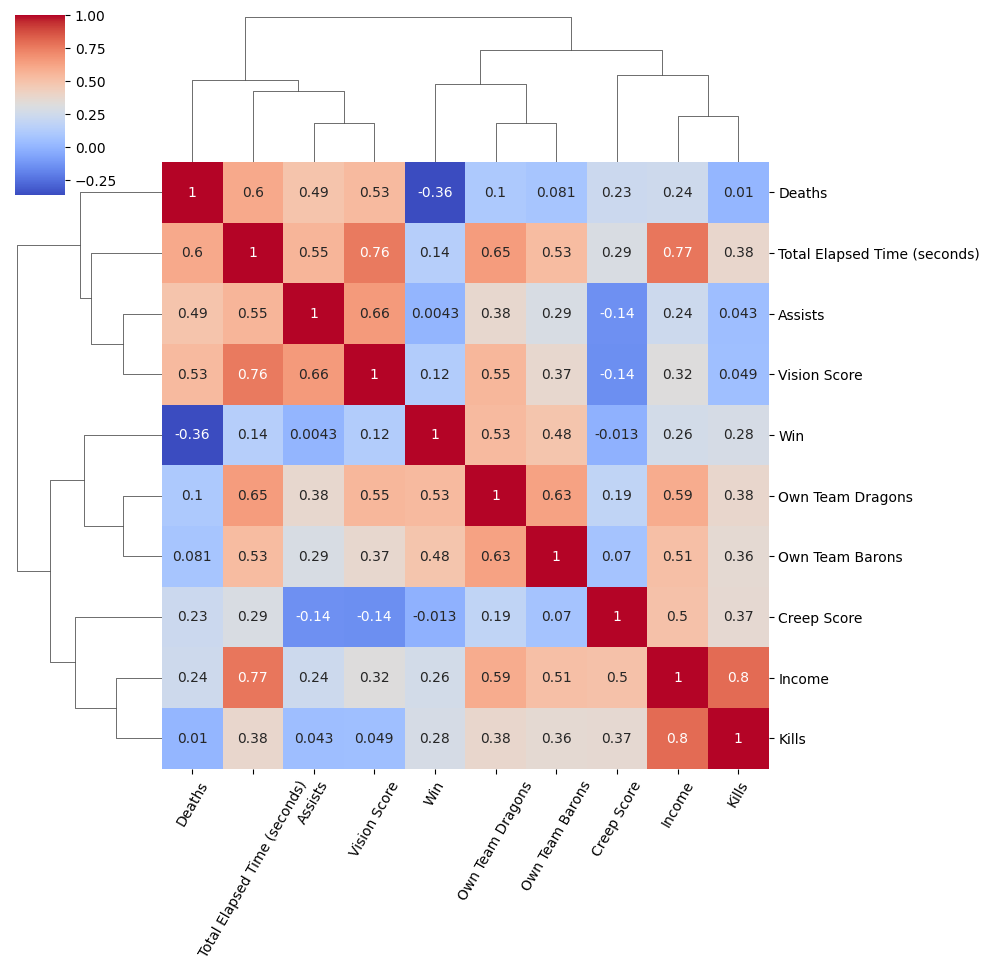

In [ ]:
ax = sns.clustermap(df.corr(),
                   method = 'complete',
                   cmap   = 'coolwarm',
                   annot  = True,
                   annot_kws = {'size': 10})
plt.setp(ax.ax_heatmap.get_xticklabels(), rotation=60);

In [ ]:
# Divide the games into quartiles based on "Total Elapsed Time"
quartile_labels = ["Q1", "Q2", "Q3", "Q4"]
df["Time Quartile"] = pd.qcut(df["Total Elapsed Time (seconds)"], q=4, labels=quartile_labels)

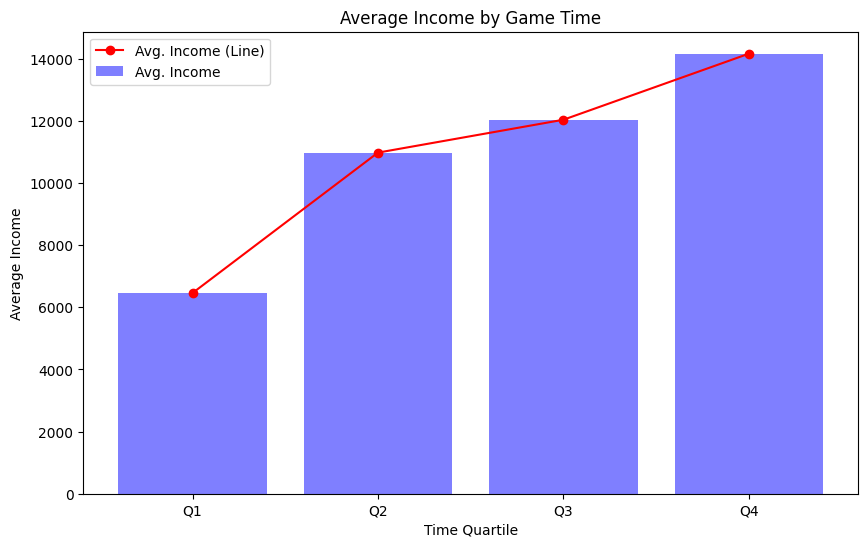

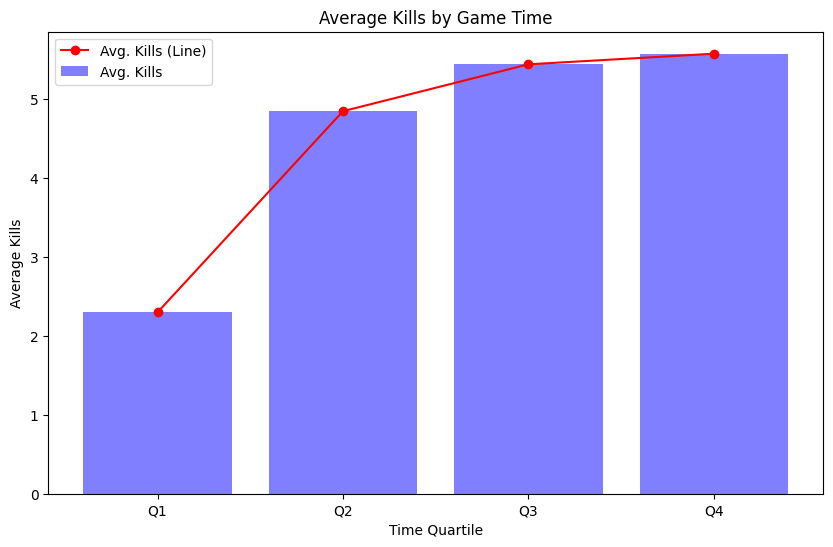

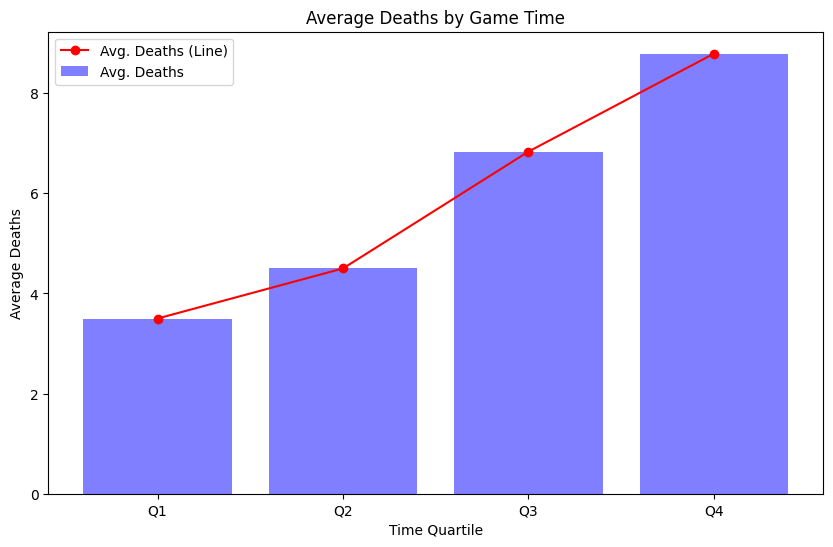

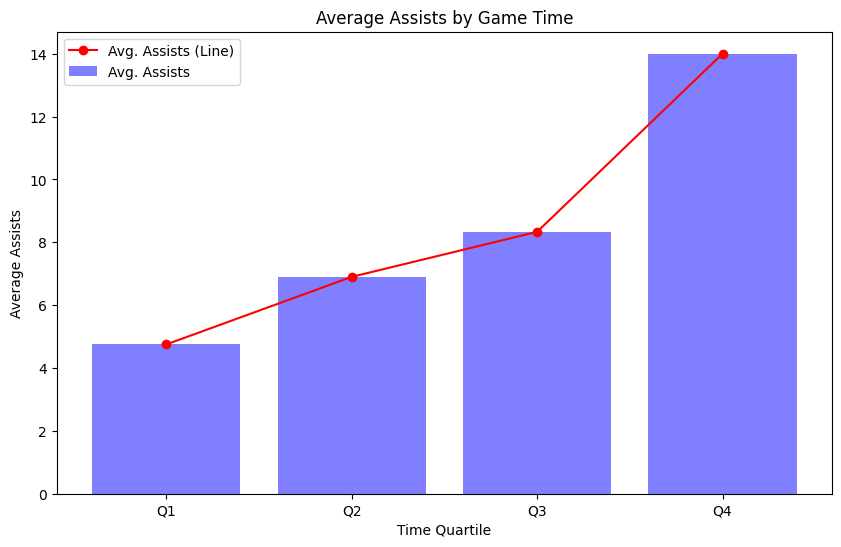

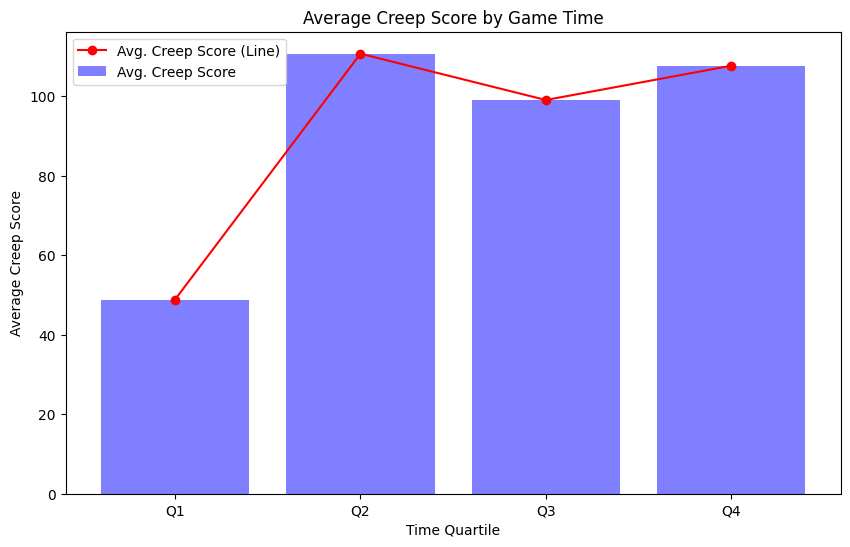

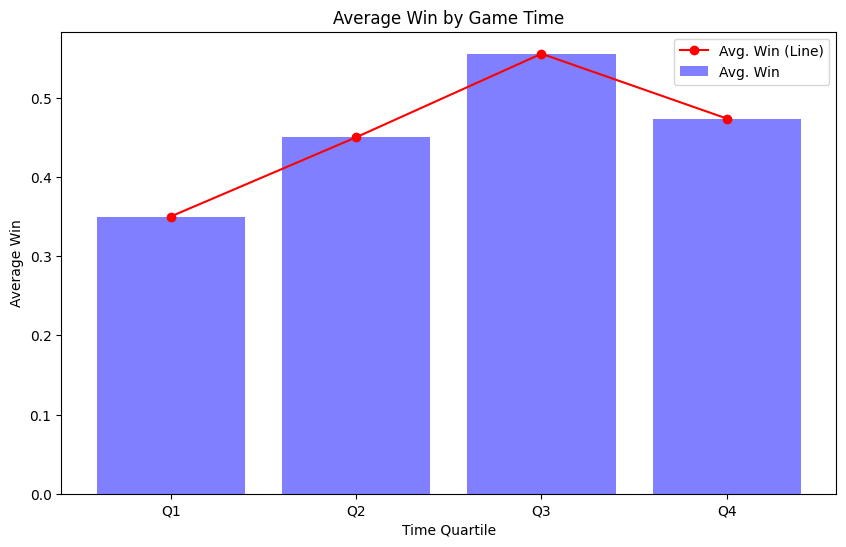

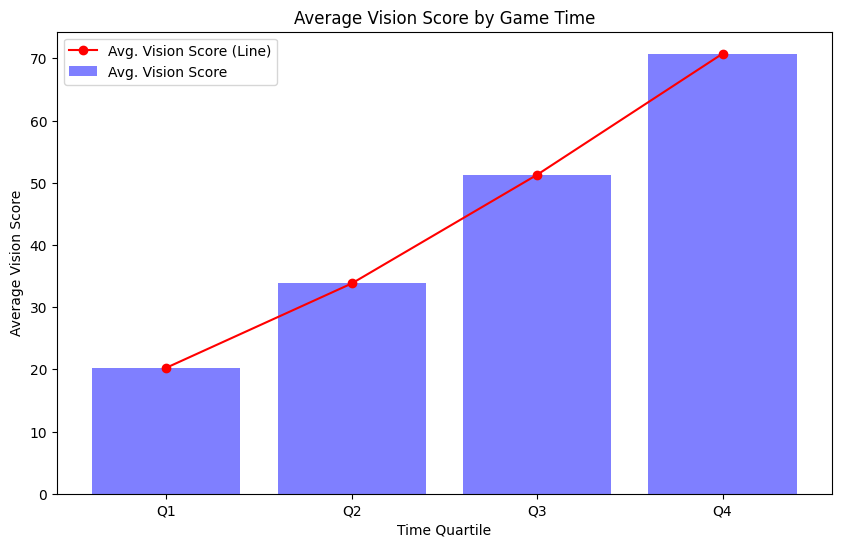

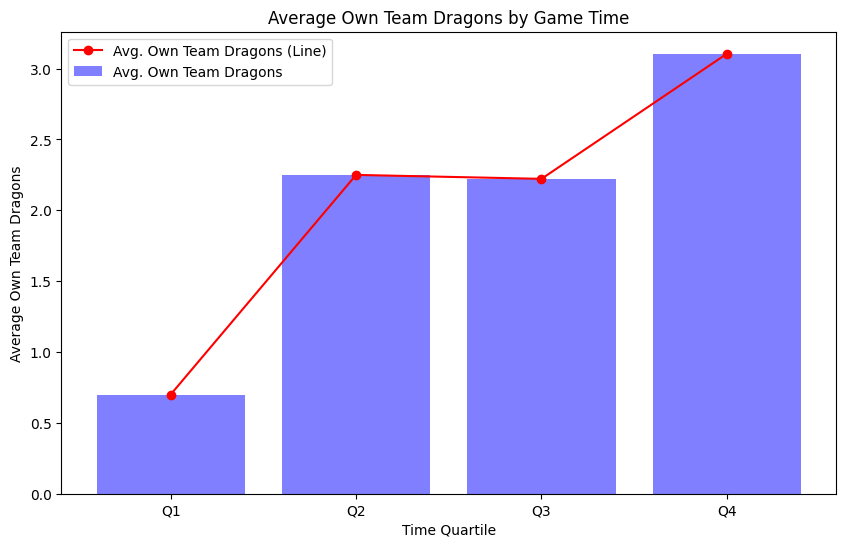

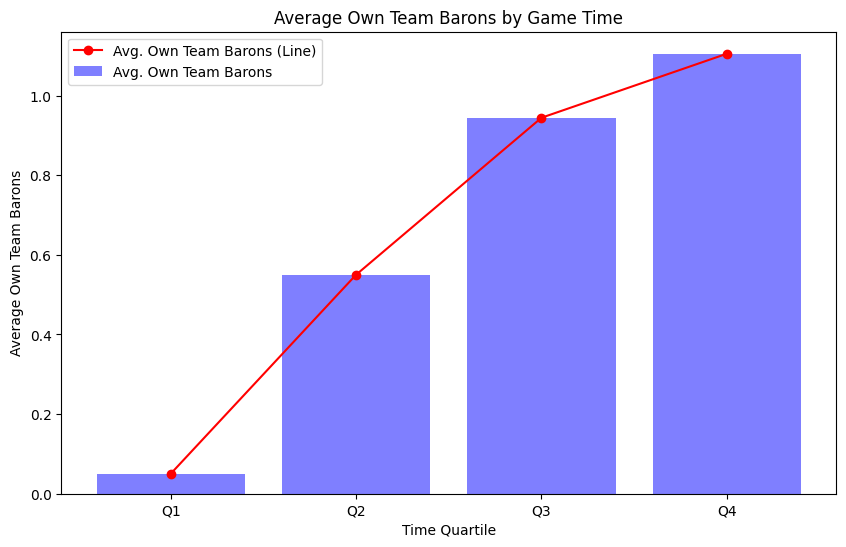

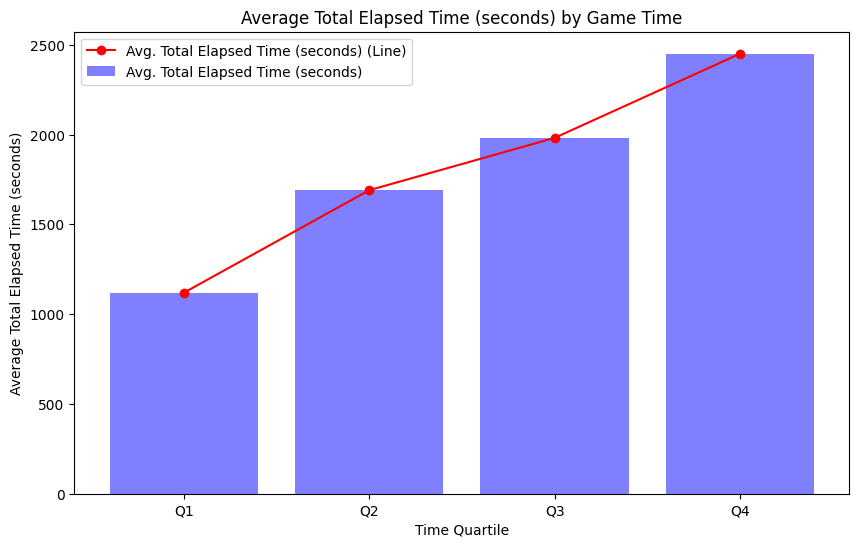

In [ ]:
average_values = df.groupby("Time Quartile").mean()

# Loop through each column and create a bar-line graph
for column in df.columns:
    if column not in ["Total Elapsed Time (minutes:seconds)", "Time Quartile"]:
        column_values = average_values[column]
        plt.figure(figsize=(10, 6))
        plt.bar(column_values.index, column_values, label=f"Avg. {column}", color='b', alpha=0.5)
        plt.plot(column_values.index, column_values, marker='o', color='r', label=f"Avg. {column} (Line)")
        plt.title(f"Average {column} by Game Time")
        plt.ylabel(f"Average {column}")
        plt.xlabel("Time Quartile")
        plt.xticks(rotation=0)
        plt.legend()
        plt.show()

In [ ]:
# Sort the DataFrame by "Total Elapsed Time (seconds)" column
df_sorted = df.sort_values(by="Total Elapsed Time (seconds)")

# Reset the index to be based on the sorted order
df_sorted.reset_index(drop=True, inplace=True)
df_sorted.index.name = "Total Elapsed Time (seconds)"

print(df_sorted)

                              Income  Kills  Deaths  Assists  Creep Score  \
Total Elapsed Time (seconds)                                                
0                                500      0       0        0            0   
1                               1284      0       0        0            0   
2                               3513      0       7        0           73   
3                               5212      2       2        8            9   
4                               4330      1       5        6            9   
...                              ...    ...     ...      ...          ...   
72                             18533     10       9        8          269   
73                             11569      1      15       28           22   
74                             12448      4      13       23           57   
75                             16275      3      13        7          292   
76                             11770      2      12       11           45   

In [ ]:
df = df.drop(columns=["Time Quartile"])

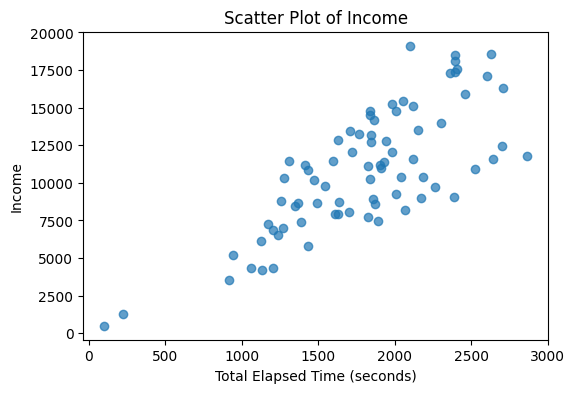

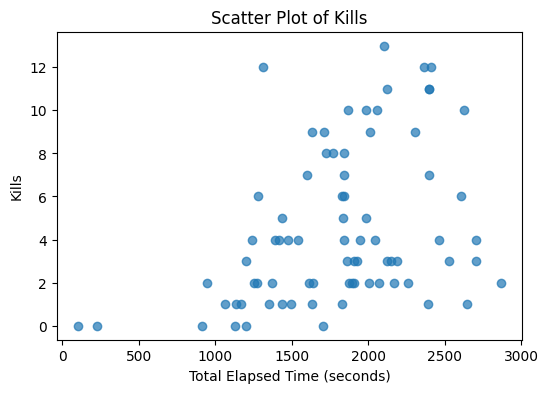

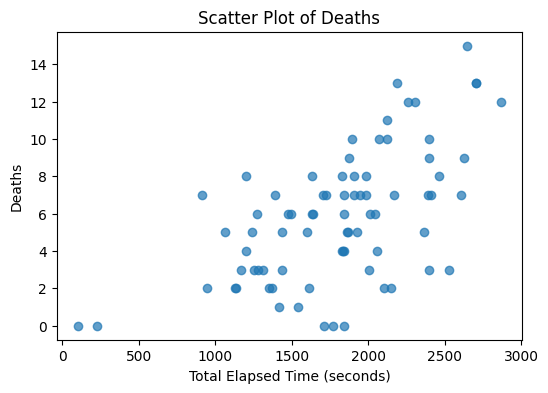

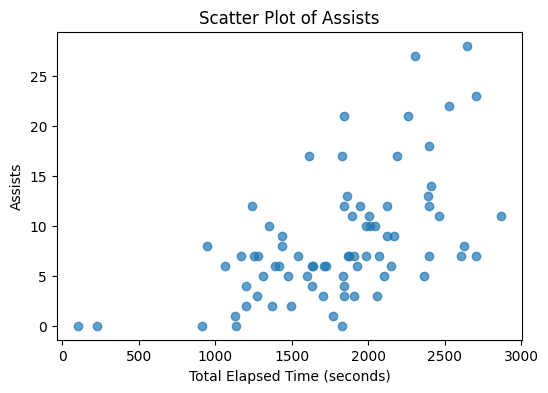

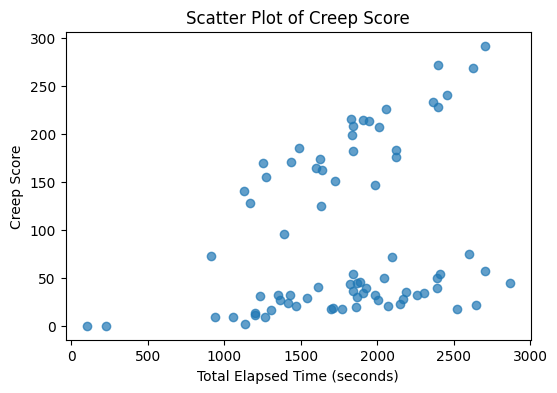

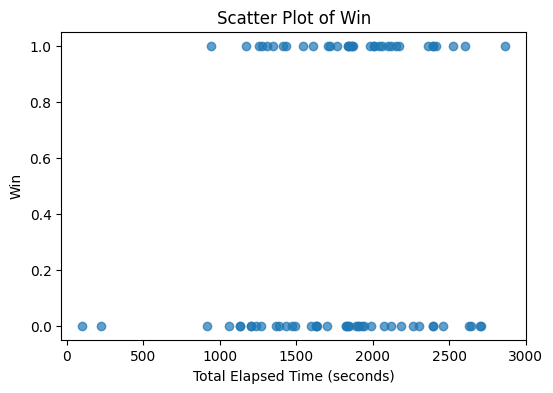

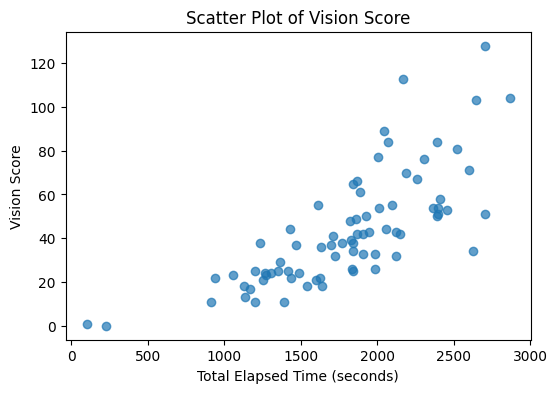

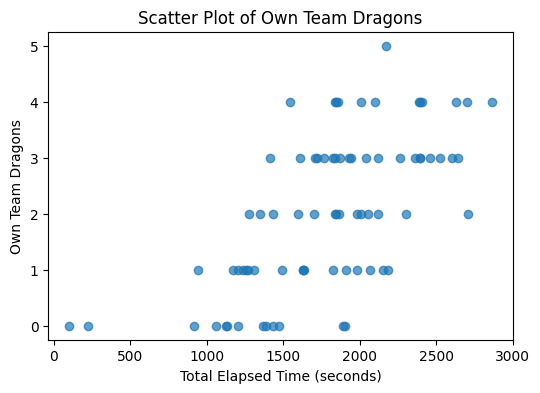

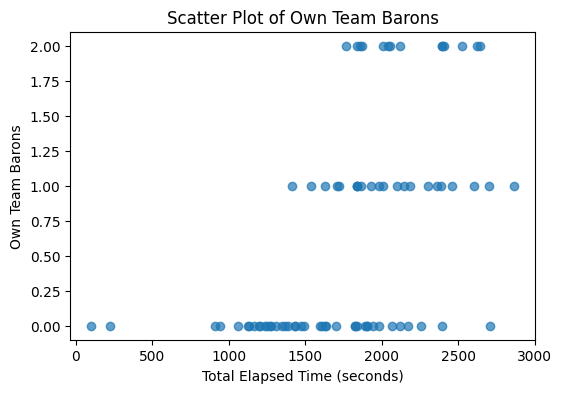

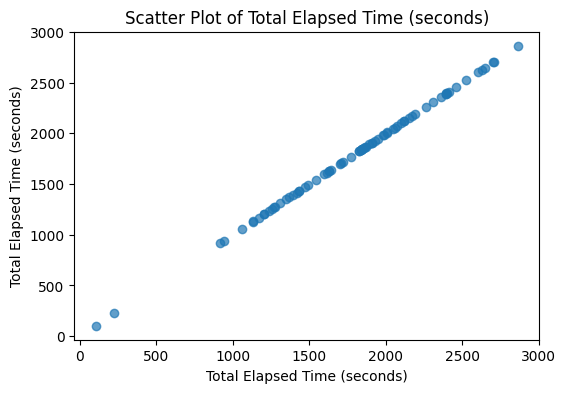

In [ ]:
for column in df.columns:
    if df[column].dtype == 'int64' or df[column].dtype == 'float64':
        plt.figure(figsize=(6, 4))
        plt.scatter(df_sorted["Total Elapsed Time (seconds)"], df_sorted[column], alpha=0.7, marker='o')
        plt.title(f"Scatter Plot of {column}")
        plt.xlabel("Total Elapsed Time (seconds)")
        plt.ylabel(column)
        plt.show()

# Machine Learning

---



In [ ]:
# Split the data into X (independent variables) and y (dependent variable)
X = df.drop(columns=["Win"])  # Independent variables
y = df["Win"]  # Dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
scaler = StandardScaler()   #scale and transform the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Perform logistic regression on scaled data
lr = LogisticRegression(solver="lbfgs", max_iter=1000)
lr.fit(X_train_scaled, y_train)
lr_score = lr.score(X_test_scaled, y_test)
lr_predictions = lr.predict(X_test_scaled)
print("Accuracy of logistic regression on scaled data: {:.3f}".format(lr_score))

Accuracy of logistic regression on scaled data: 0.792


In [ ]:
coeff_df = pd.DataFrame(X.columns)
coeff_df.columns = ['Feature']
coeff_df["Coefficient"] = pd.Series(lr.coef_[0])

# Sort the DataFrame by the coefficient values in descending order
coeff_df_sorted = coeff_df.sort_values(by='Coefficient', ascending=False)

print(coeff_df_sorted)

                        Feature  Coefficient
6              Own Team Dragons     0.983431
7               Own Team Barons     0.813703
5                  Vision Score     0.501462
1                         Kills     0.317627
0                        Income    -0.055116
4                   Creep Score    -0.091594
8  Total Elapsed Time (seconds)    -0.165877
3                       Assists    -0.170114
2                        Deaths    -1.065939


In [ ]:
# Make predictions
y_pred = lr.predict(X_test_scaled)

# Generate and print the classification report
lr_report = classification_report(y_test, y_pred)
print(lr_report)

              precision    recall  f1-score   support

           0       0.75      0.92      0.83        13
           1       0.88      0.64      0.74        11

    accuracy                           0.79        24
   macro avg       0.81      0.78      0.78        24
weighted avg       0.81      0.79      0.79        24



In [ ]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

100.0

In [ ]:
knn1_report = classification_report(y_test, Y_pred)
print(knn1_report)

              precision    recall  f1-score   support

           0       0.57      0.62      0.59        13
           1       0.50      0.45      0.48        11

    accuracy                           0.54        24
   macro avg       0.54      0.53      0.53        24
weighted avg       0.54      0.54      0.54        24



In [ ]:
# Define the parameter grid
param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)  # Assuming you have scaled X_train as shown earlier

# Print the best parameter value and corresponding score
print("Best n_neighbors:", grid_search.best_params_['n_neighbors'])
print("Best score:", grid_search.best_score_)

Best n_neighbors: 5
Best score: 0.850909090909091


In [ ]:
knn = KNeighborsClassifier(n_neighbors =5)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn_best = round(knn.score(X_train, y_train) * 100, 2)
acc_knn_best

71.7

In [ ]:
knn3_report = classification_report(y_test, Y_pred)
print(knn3_report)

              precision    recall  f1-score   support

           0       0.57      0.62      0.59        13
           1       0.50      0.45      0.48        11

    accuracy                           0.54        24
   macro avg       0.54      0.53      0.53        24
weighted avg       0.54      0.54      0.54        24



In [ ]:
def process_svm_kernels(X_train, X_test, y_train):
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    accuracies = {}

    for kernel in kernels:
        svm1 = svm.SVC(kernel=kernel)
        svm1.fit(X_train, y_train)
        y_pred = svm1.predict(X_test)
        acc_svm = round(svm1.score(X_train, y_train) * 100, 2)
        print(f"Kernel: {kernel}, Accuracy: {acc_svm}")
    return accuracies

kernel_accuracies = process_svm_kernels(X_train, X_test, y_train)

for kernel, accuracy in kernel_accuracies.items():
    print(f"Kernel: {kernel}, Accuracy: {accuracy}")

Kernel: linear, Accuracy: 83.02
Kernel: poly, Accuracy: 58.49
Kernel: rbf, Accuracy: 62.26
Kernel: sigmoid, Accuracy: 54.72


In [ ]:
svm2=svm.SVC(kernel = 'linear')
svm2.fit(X_train, y_train)
Y_pred=svm2.predict(X_test)
svm_acc = round(svm2.score(X_train, y_train) *100, 2)
svm_acc

83.02

In [ ]:
svm_report = classification_report(y_test, Y_pred)
print(svm_report)

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.83      0.91      0.87        11

    accuracy                           0.88        24
   macro avg       0.88      0.88      0.87        24
weighted avg       0.88      0.88      0.88        24



In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

100.0

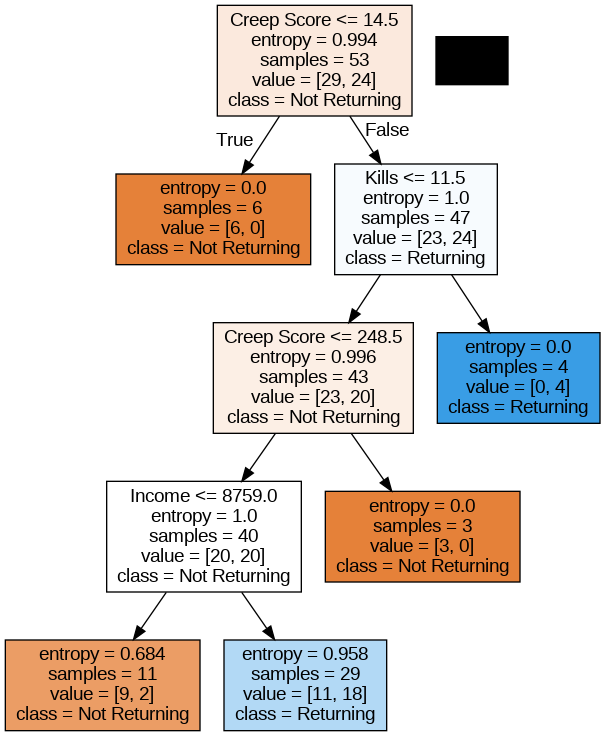

In [ ]:
# Initialize and train the tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)
decision_tree.fit(X_train, y_train)

# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X_train.columns,
    class_names=['Not Returning', 'Returning'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())
#This is a map of the decision tree nodes

In [ ]:
tree_report = classification_report(y_test, Y_pred)
print(tree_report)

              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.71      0.91      0.80        11

    accuracy                           0.79        24
   macro avg       0.81      0.80      0.79        24
weighted avg       0.81      0.79      0.79        24



In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of trees
    'max_features': ['sqrt', 'log2'],    # Maximum number of features
}

# Create the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Perform grid search using cross-validation on the training data
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train a Random Forest model with the best parameters using the full training data
best_rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                 max_features=best_params['max_features'],
                                 random_state=42)
best_rf.fit(X_train, y_train)

# Perform cross-validation on the model
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5)

# Calculate the average accuracy across all cross-validation folds
average_accuracy = cv_scores.mean()
print("Average Accuracy:", average_accuracy)

Best Parameters: {'max_features': 'sqrt', 'n_estimators': 150}
Best Score: 0.830909090909091
Average Accuracy: 0.830909090909091


In [ ]:
random_forest = RandomForestClassifier(n_estimators=150, max_features='sqrt', random_state = 42)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest
#The highest scoring classification report

100.0

In [ ]:
forest_report = classification_report(y_test, Y_pred)
print(forest_report)

              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.71      0.91      0.80        11

    accuracy                           0.79        24
   macro avg       0.81      0.80      0.79        24
weighted avg       0.81      0.79      0.79        24



In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest
#This, combined with the actual decision tree, are our highest model predictors
#After submitting the powerpoint slide, i realized this one had the highest score

100.0

In [ ]:
class_report = classification_report(y_test, Y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.79      1.00      0.88        11

    accuracy                           0.88        24
   macro avg       0.89      0.88      0.87        24
weighted avg       0.90      0.88      0.87        24



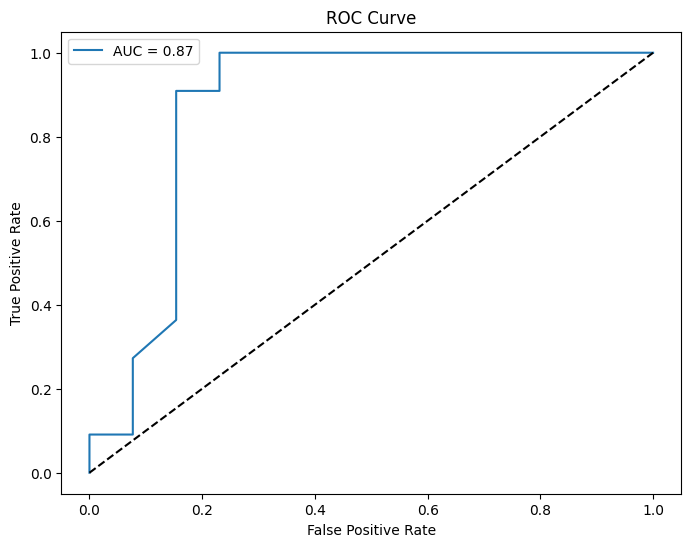

AUC Score: 0.87


In [ ]:
# Predict probabilities for the positive class
y_pred_probs = random_forest.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
auc_score = roc_auc_score(y_test, y_pred_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line to show a coin flip
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f"AUC Score: {auc_score:.2f}")